## MEMA Inter-subject analysis

This notebook will 
- Process and generate reports for all the dataset following procedure detailed in Bruxism detection
- Display several metrics for all patients of the datasets
- Display group analysis differences between tinnitus overnight increase patients and stable overnight patients (for tinnitus masking volume and VAS scales)
- Display correlation plots between tinnitus evolution overnight and number of bruxisme episodes per hour (for tinnitus masking volume and VAS scales)

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import scipy

print("config loaded")


config loaded


In [2]:
#Setting parameters
results_file = "data/reports_and_datas_MEMA.pk"
info_file = "data/data_info.csv"

# PART 1 Compute Results
Skip to Part 2 if results files has been computed already

## Processing of the dataset and report generation

In [3]:
# change --overwrite to True if you want to force to recompute the results
%run ../compute_results.py --mema True --overwrite False 

config loaded.
Performs Bruxism: <False>
Performs MEMA: <True>
Will overwrite existing results: <False>
parameters set
result files exist: Reports creation skipped.


# Part 2 Load and Analysis Results
Part 1 is optional if the .pk has been saved

### Loading results

In [4]:
results = pd.read_pickle(results_file).to_dict()
THR_classif = np.array(results[list(results.keys())[0]]["THR_classif"])

data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & session == "1" ')
#data_info = pd.read_csv(info_file, sep=";").query('mema == 1 & included == 1 & subject == "1SL21" & session != "6" ')

print(f"Valid files for mema {data_info.shape[0]}")
print(data_info[["filename", "condition"]])
results_updated = dict()
for filename in results.keys():
    if filename in data_info["filename"].values:
        results_updated[filename] = results[filename]
results = results_updated

Valid files for mema 10
              filename    condition
4   1DA15_nuit_hab.edf  habituation
9   1GB18_nuit_hab.edf  habituation
22  1RA17_nuit_hab.edf  habituation
28    1HB20_nuit_1.edf  habituation
36    1SL21_nuit_2.edf  habituation
40    1UC22_nuit_1.edf  habituation
42    2GA06_nuit_1.edf      control
43    2SJ03_nuit_1.edf      control
49    2LS05_nuit_1.edf      control
50    2CT04_nuit_1.edf      control


## Data visualization for the entire cohort for nb MEMA episodes per hour as a function of THR_classif value : 

In [5]:
def plot_inter_subjects(results, value): 
    for filename in results.keys():
        y_axis=[]
        for report in results[filename]["reports"]:
            y_axis.append(report[value])
        plt.plot(THR_classif[:,1], y_axis, label=filename)
    plt.title('MEMA scoring')
    plt.xlabel('Threshold for classification')
    plt.ylabel(value)
    plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

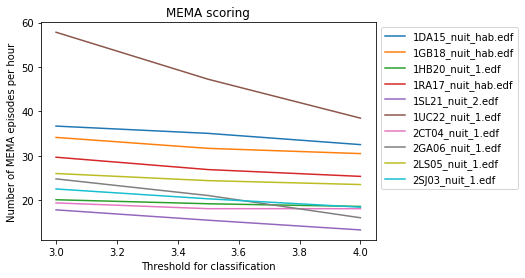

In [6]:
plt.close("all")
plt.figure()
value = "Number of MEMA episodes per hour"
plot_inter_subjects(results, value)

## Data visualization for the entire cohort for nb MEMA bursts as a function of THR_classif value : 

<Figure size 432x288 with 0 Axes>

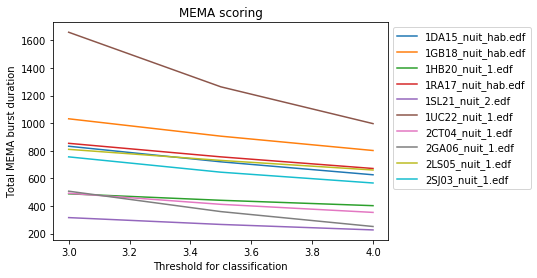

In [7]:
plt.figure()
plt.figure()
value = "Total MEMA burst duration"
plot_inter_subjects(results, value)

In [8]:
## Comparing 

In [9]:
# format reports
reports = None
for filename in results.keys():
    report = pd.DataFrame(results[filename]["reports"])
    report["THR_classif"] = THR_classif[:,1]
    report["filename"] = filename
    if reports is None:
        reports = report
    else:
        reports = reports.append(report, ignore_index=True)

        
import math     
def map_category(x):
    if x < (-0.1):
        return "decrease"
    elif x > (0.1):
        return "increase"
    elif math.isnan(x):
        return "control"
    else:
        return "stable"
data_info["category"] = data_info["VAS_L_delta"].apply(map_category)

reports = reports.merge(data_info, on="filename")

In [10]:
#Preparing values for correlation scatter plots
    
print("Nb_patients in each group : ")
for category in list(data_info['category'].unique()):
    print(f"Tinnitus {category} : {(data_info['category']==category).sum()}, {(list(data_info[data_info['category']==category]['subject']))}")

report_mean = reports.groupby(['category', 'THR_classif']).mean()
report_std =  reports.groupby(['category', 'THR_classif']).std()

Nb_patients in each group : 
Tinnitus stable : 4, ['1DA15', '1GB18', '1RA17', '1HB20']
Tinnitus decrease : 1, ['1SL21']
Tinnitus increase : 1, ['1UC22']
Tinnitus control : 4, ['2GA06', '2SJ03', '2LS05', '2CT04']


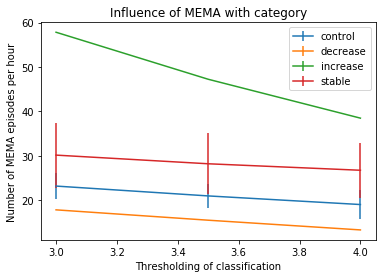

In [11]:
#Displaying
plt.figure()
value = "Number of MEMA episodes per hour"
for category in list(report_mean.index.get_level_values(0).unique()):
    plt.errorbar(THR_classif[:,1],report_mean.loc[category][value], report_std.loc[category][value], label = category)
plt.title("Influence of MEMA with category" )
plt.xlabel('Thresholding of classification')
plt.ylabel(value)
plt.legend()

In [12]:
quantitative_variables = list(results[list(results.keys())[0]]["reports"][0].keys())#[0:-1] #(remove power ratio)
print(f'variables: {quantitative_variables}')
effect_variable = ["mask_delta", "mask_per", "VAS_I_delta", "VAS_I_per", "VAS_L_delta", "VAS_L_per"]
reports["Power Ratio"] = reports["Power Ratio"].apply(sum)

variables: ['Clean MEMA duration', 'Total MEMA burst duration', 'Total number of MEMA burst', 'Number of MEMA bursts per hour', 'Total number of MEMA episodes', 'Number of MEMA bursts per episode', 'Number of MEMA episodes per hour', 'Mean duration of MEMA episode', 'Power Ratio']


<ipython-input-13-820838cf91d2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
<ipython-input-13-820838cf91d2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
<ipython-input-13-820838cf91d2>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitl

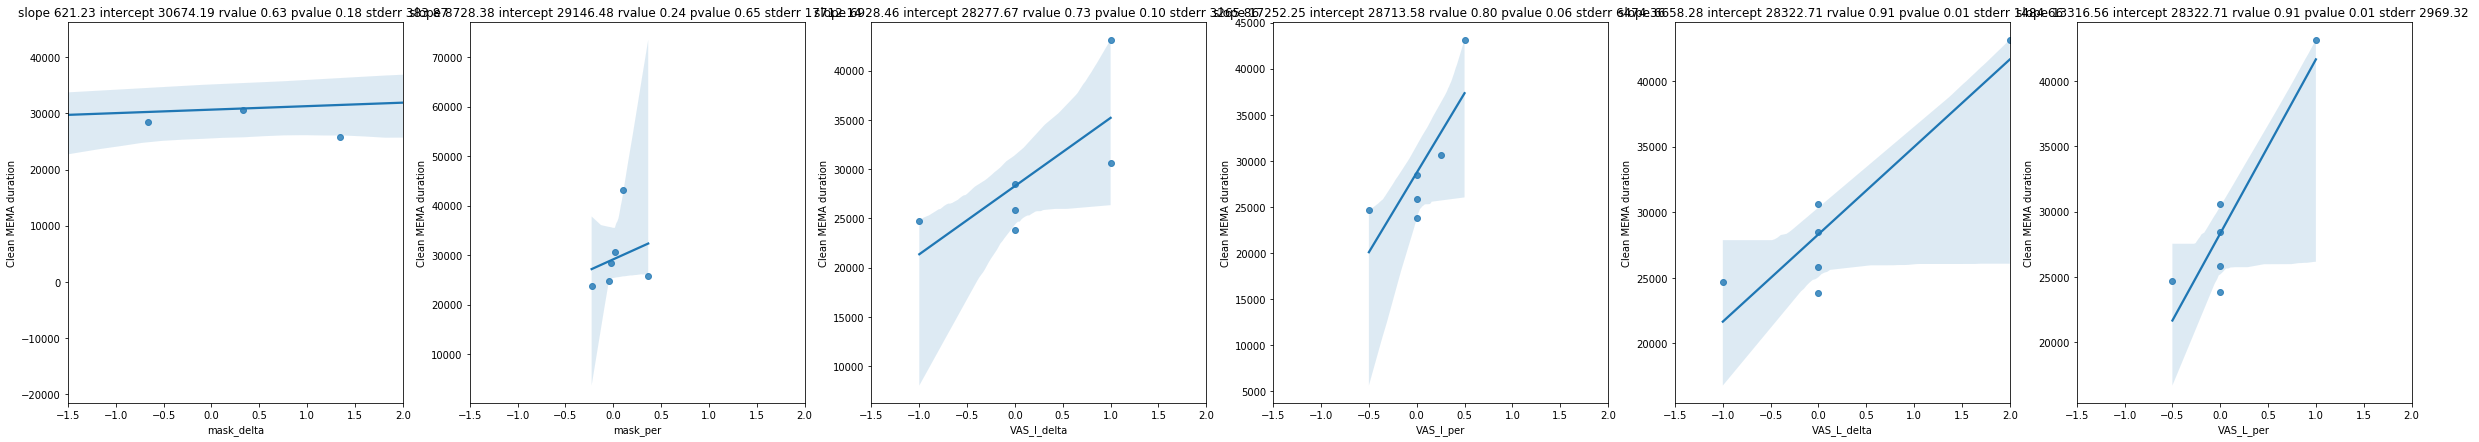

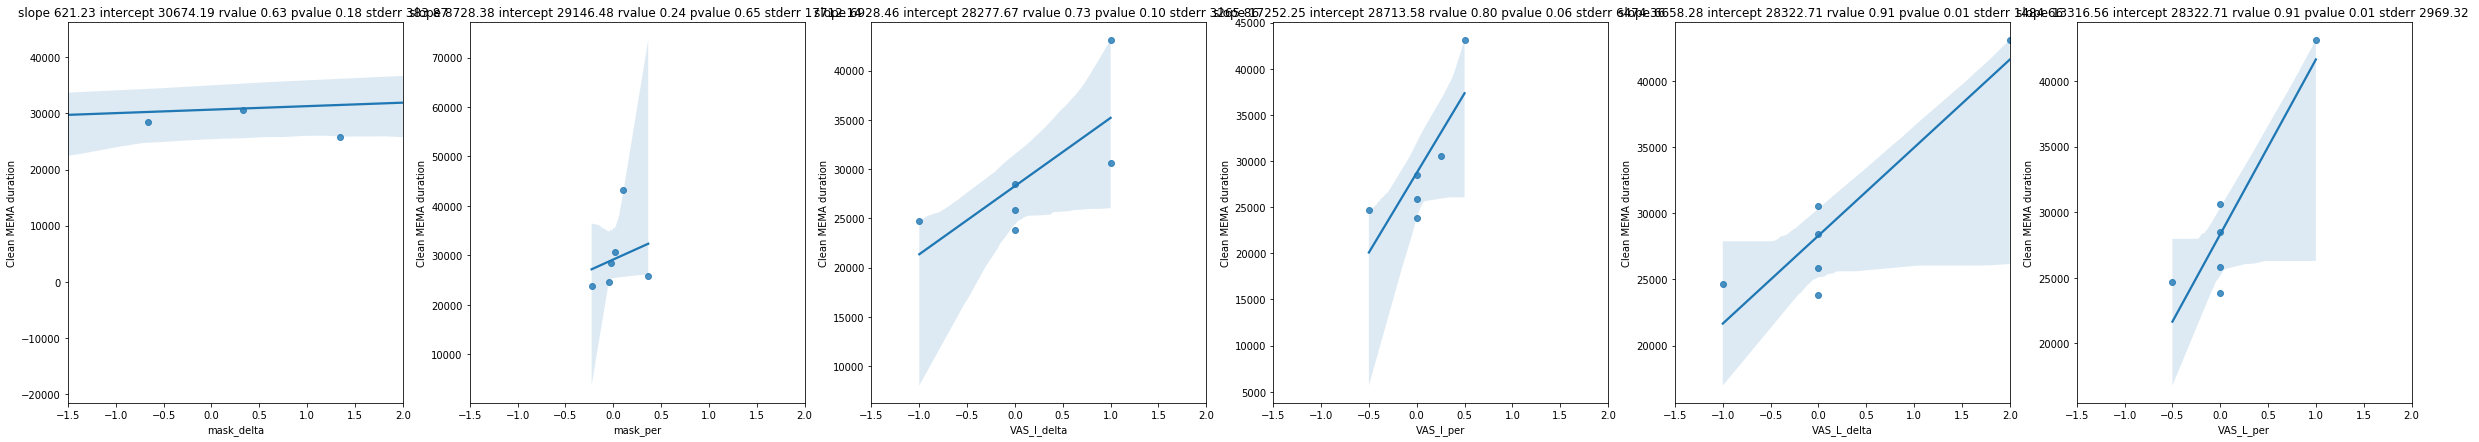

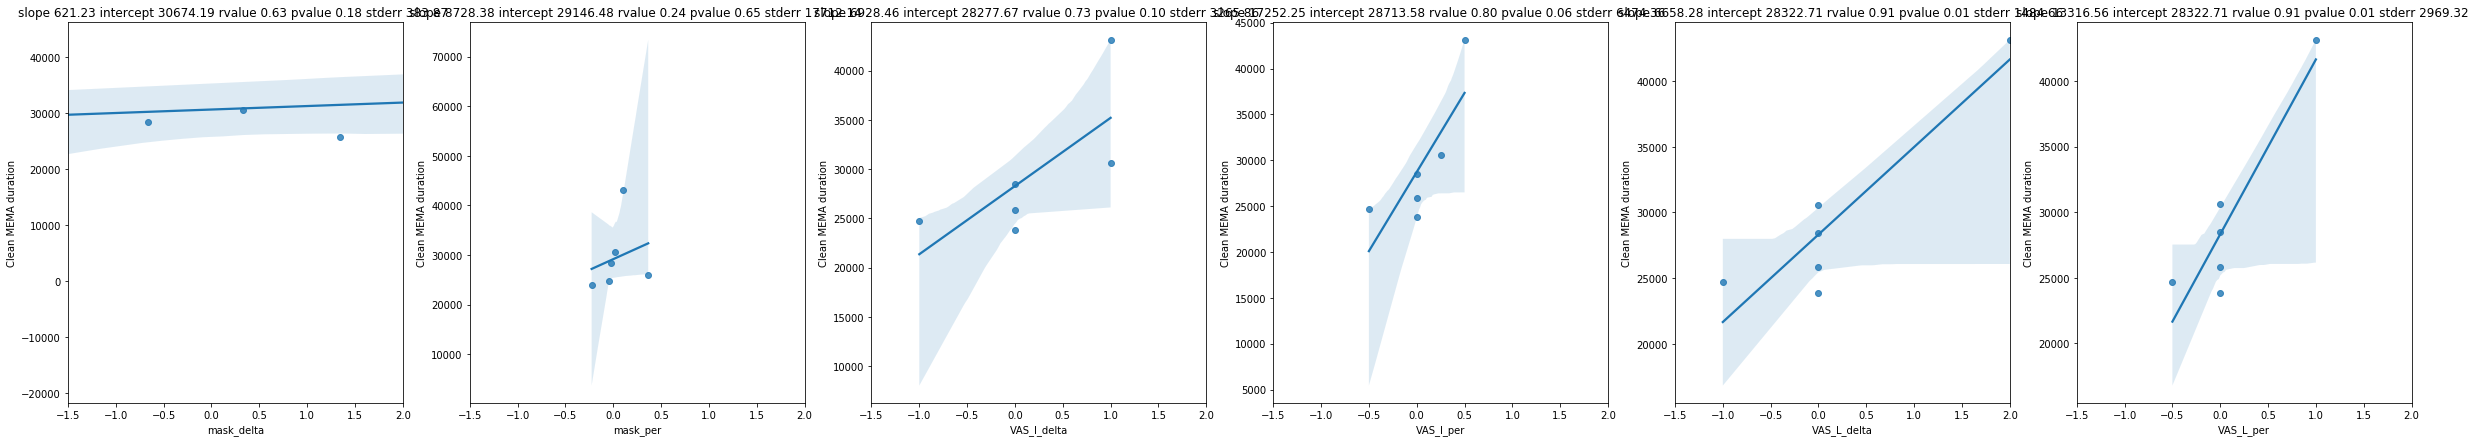

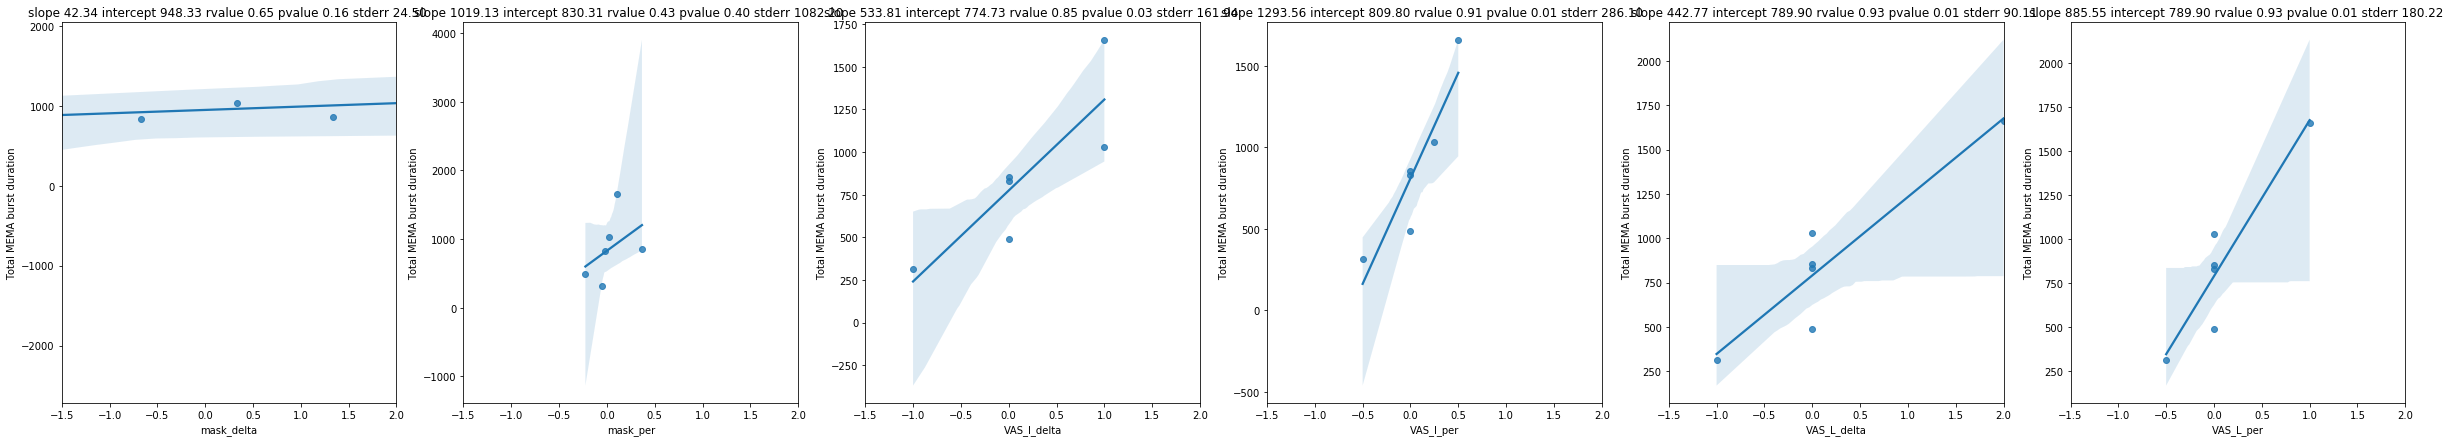

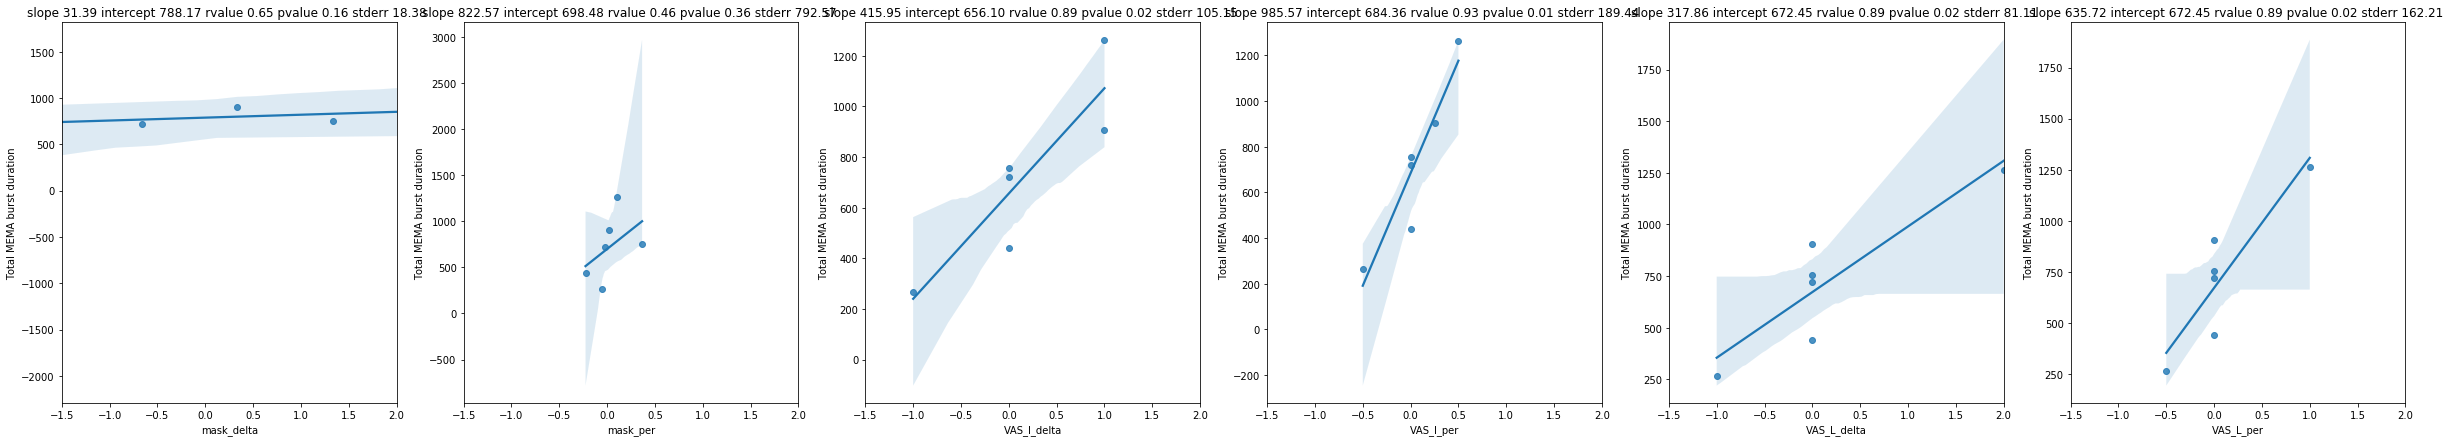

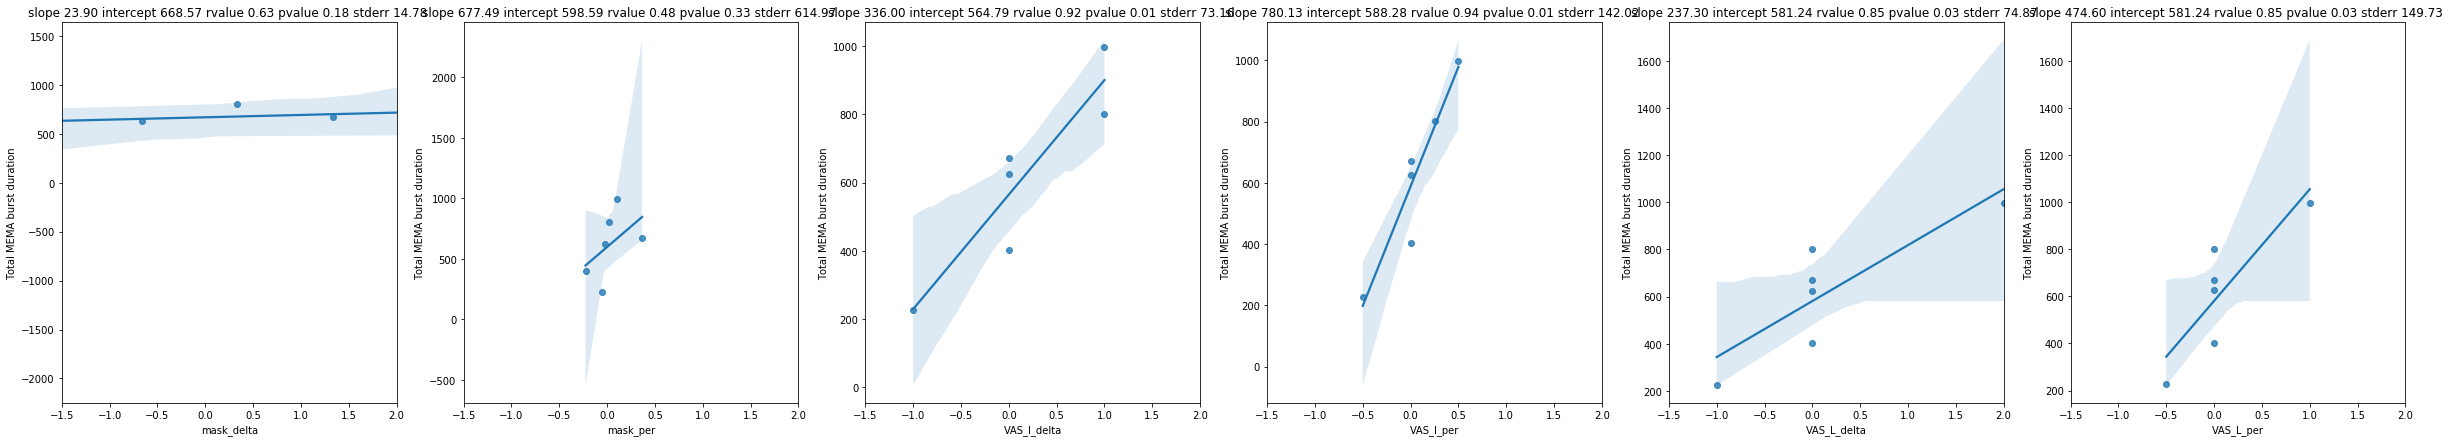

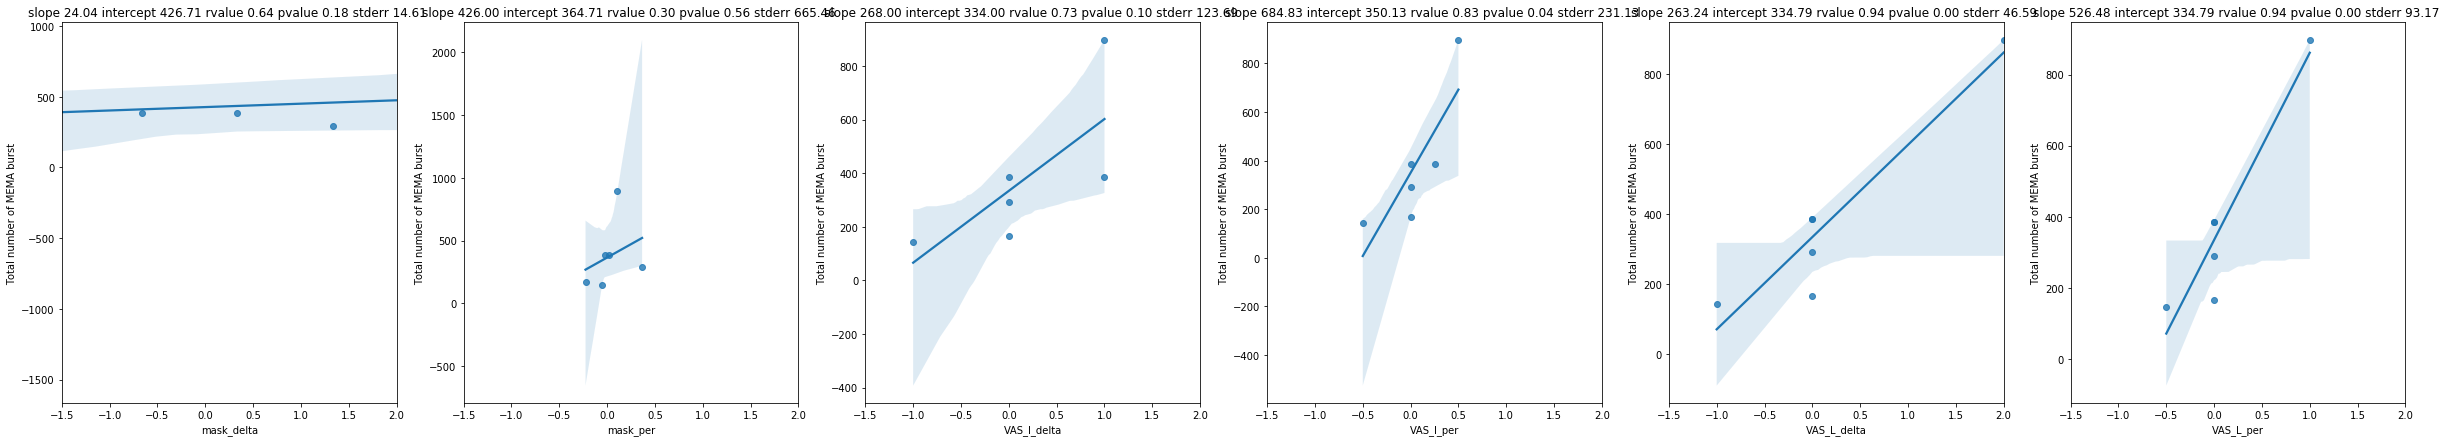

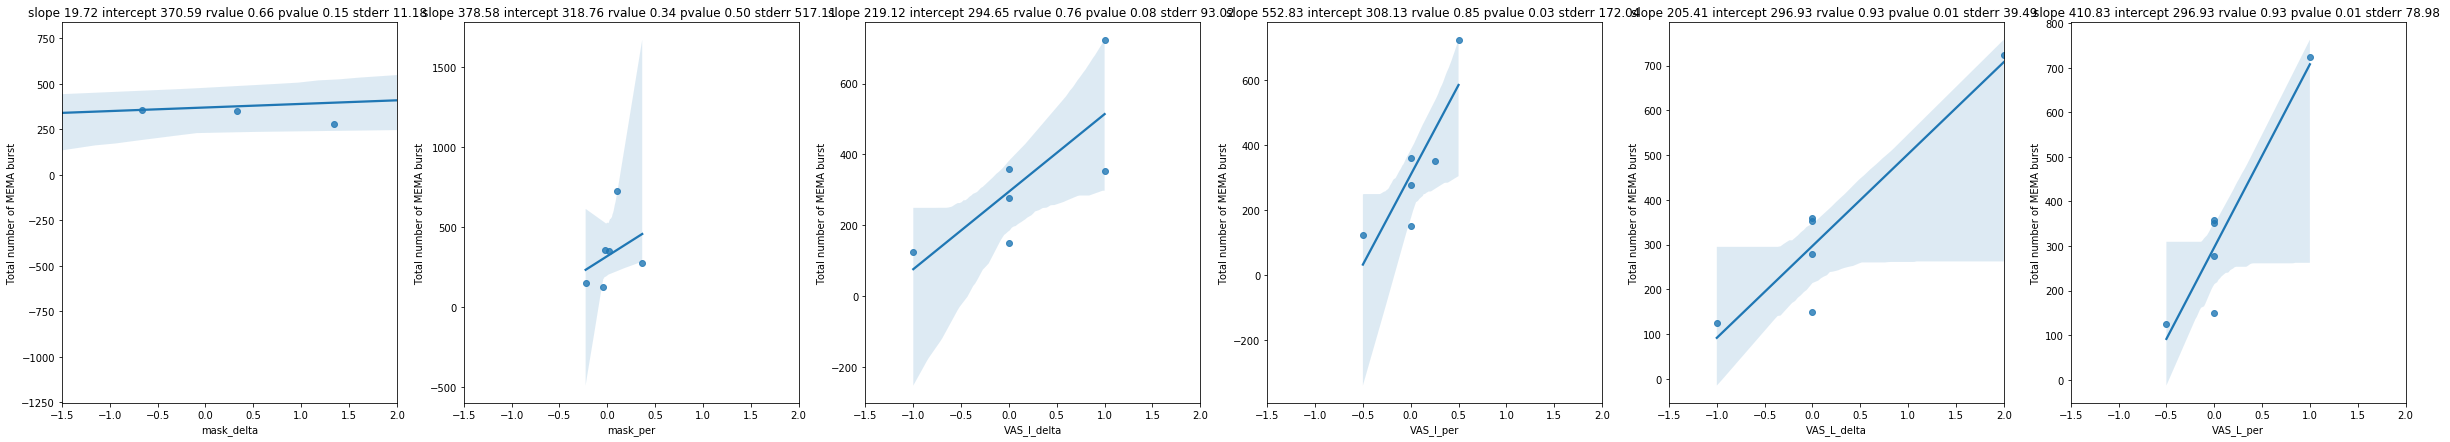

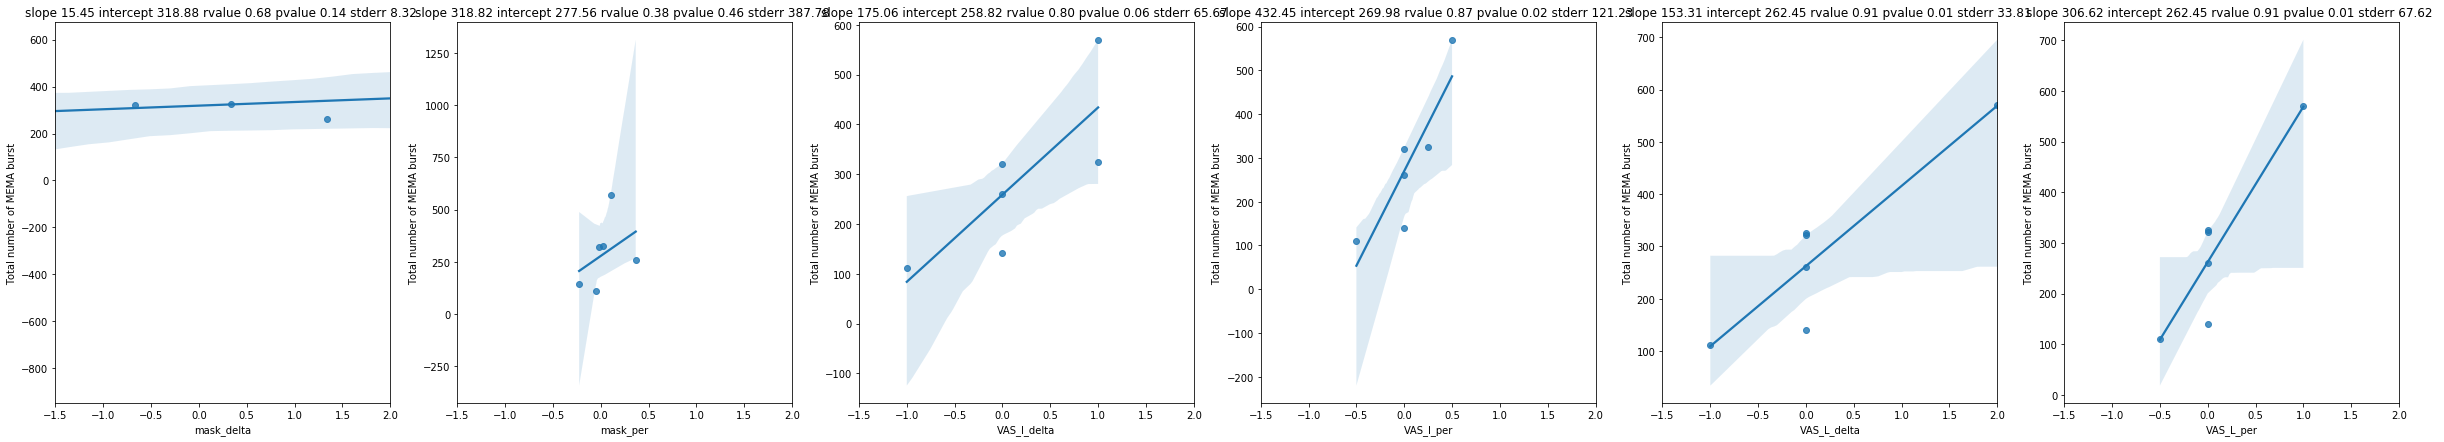

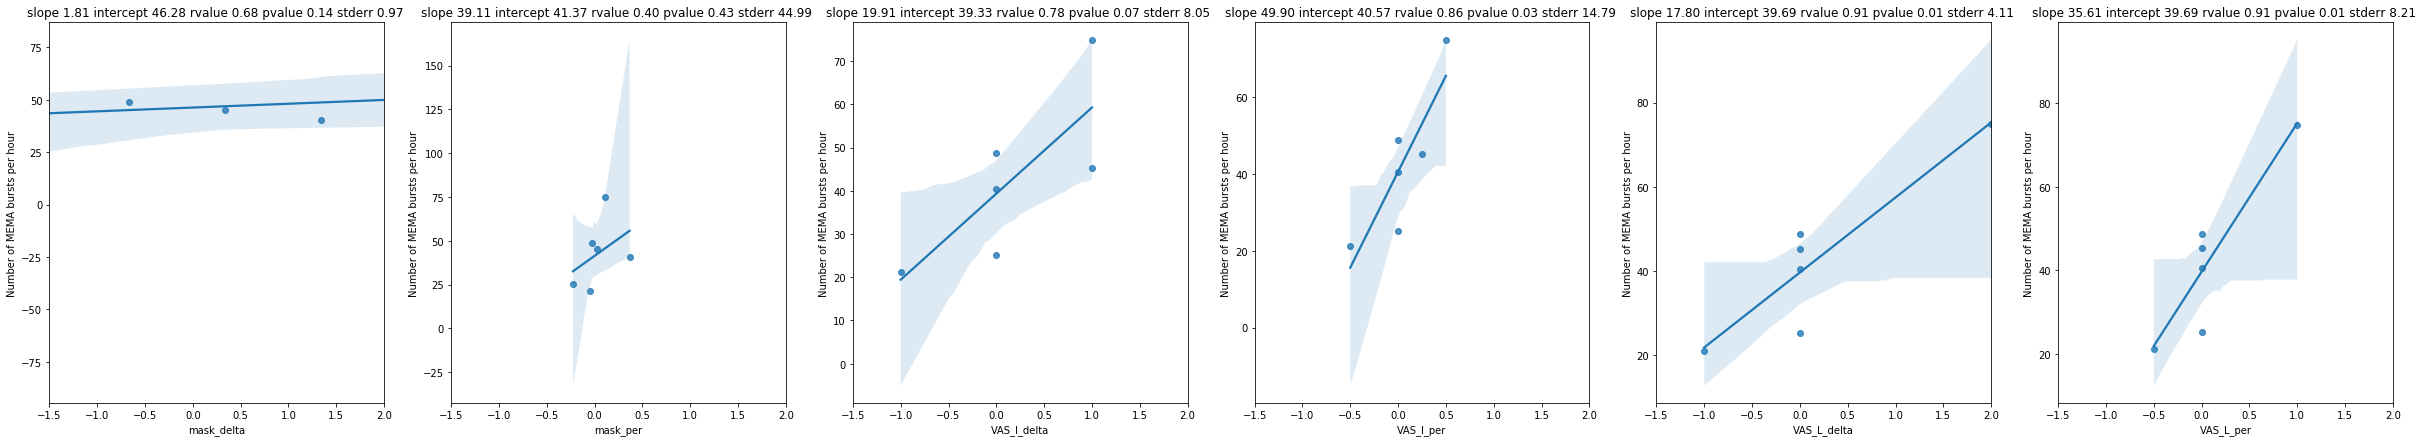

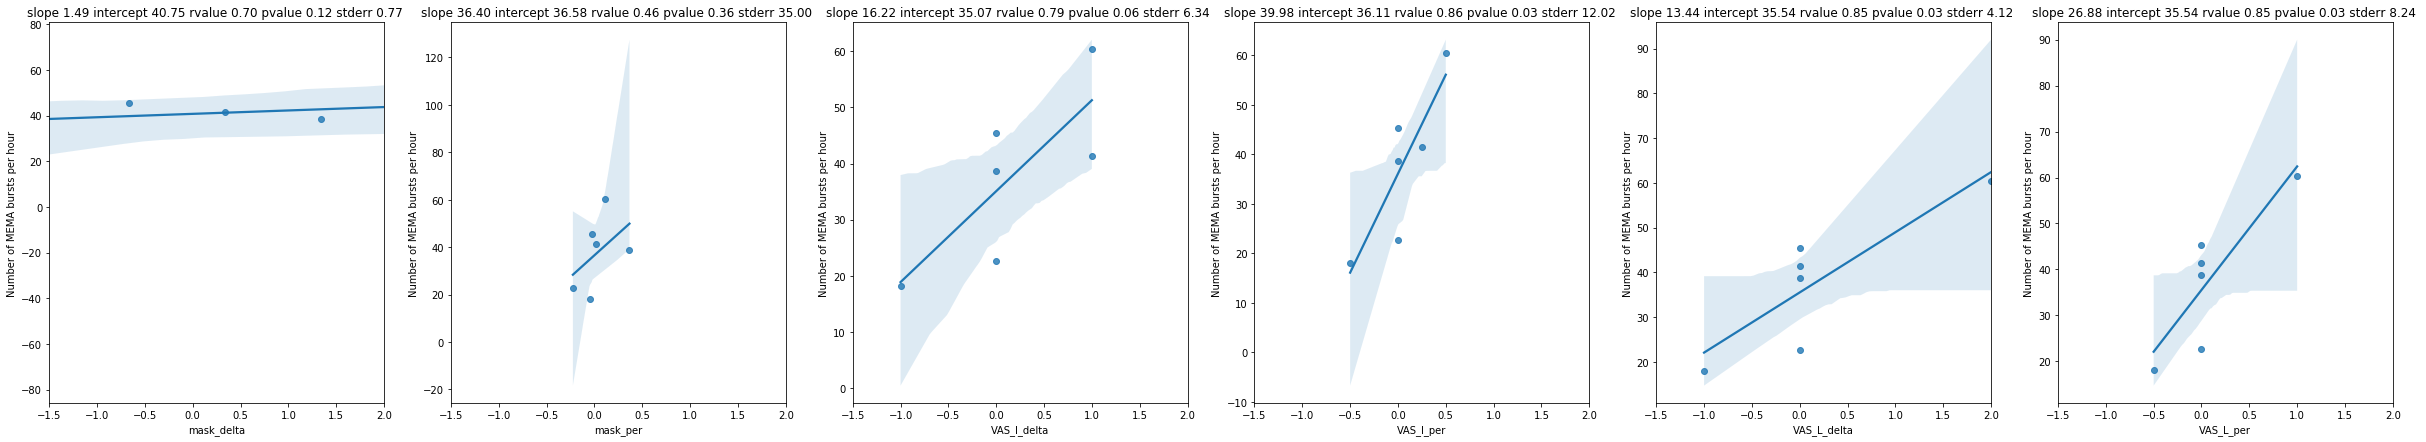

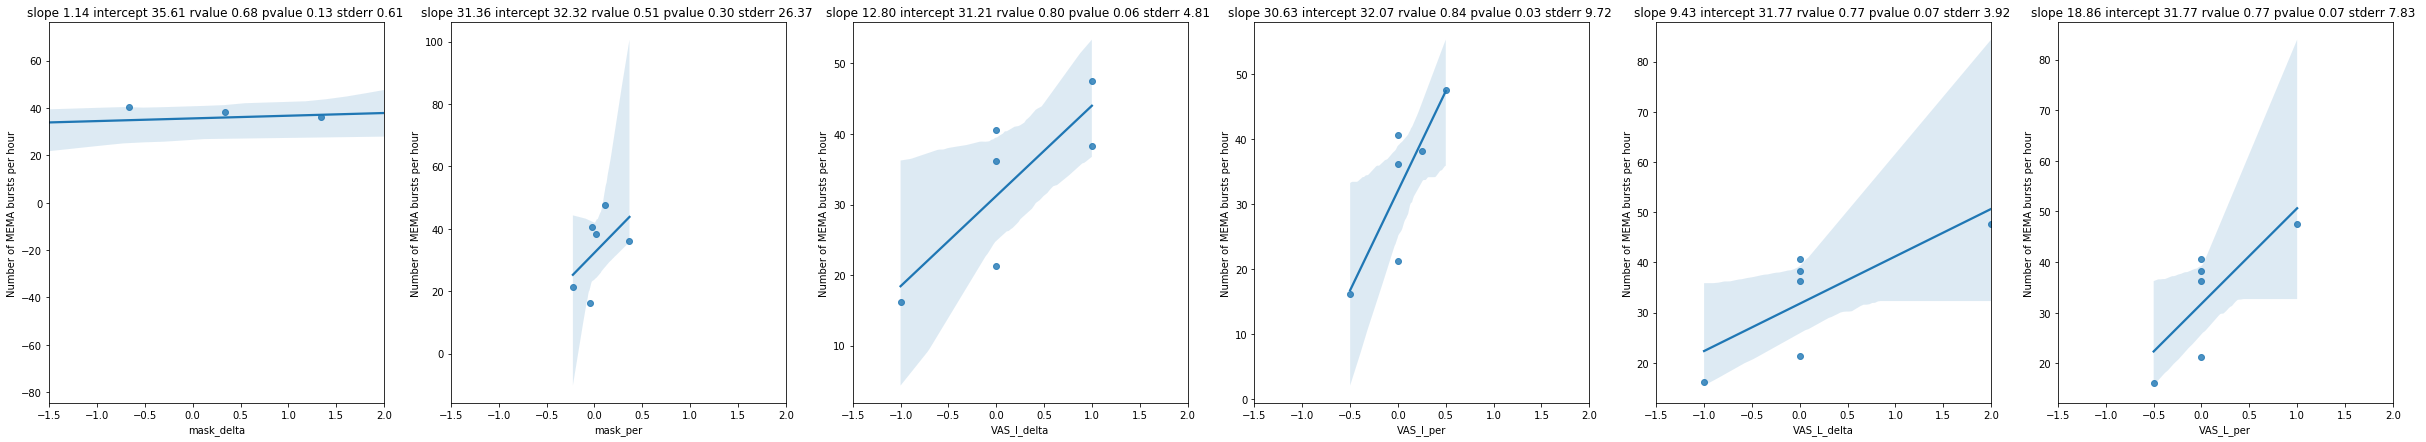

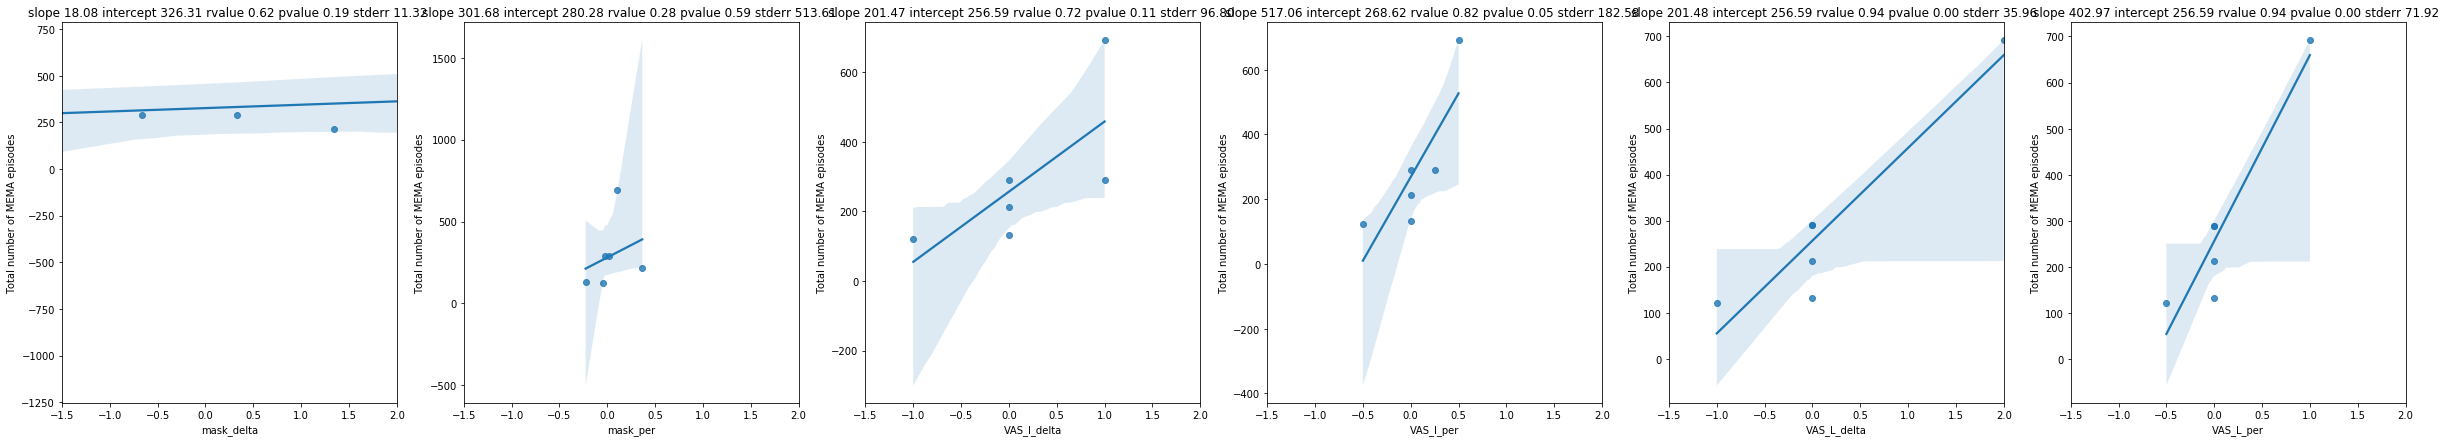

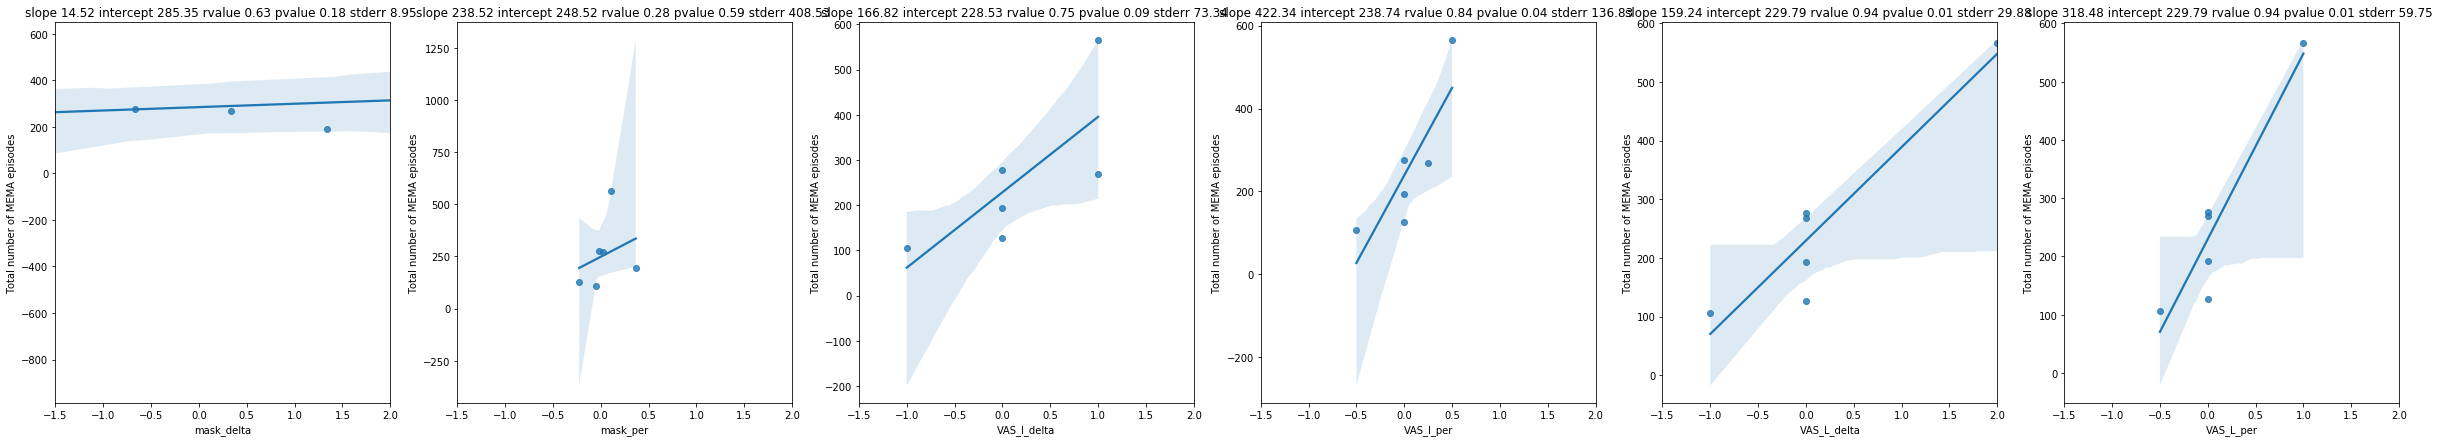

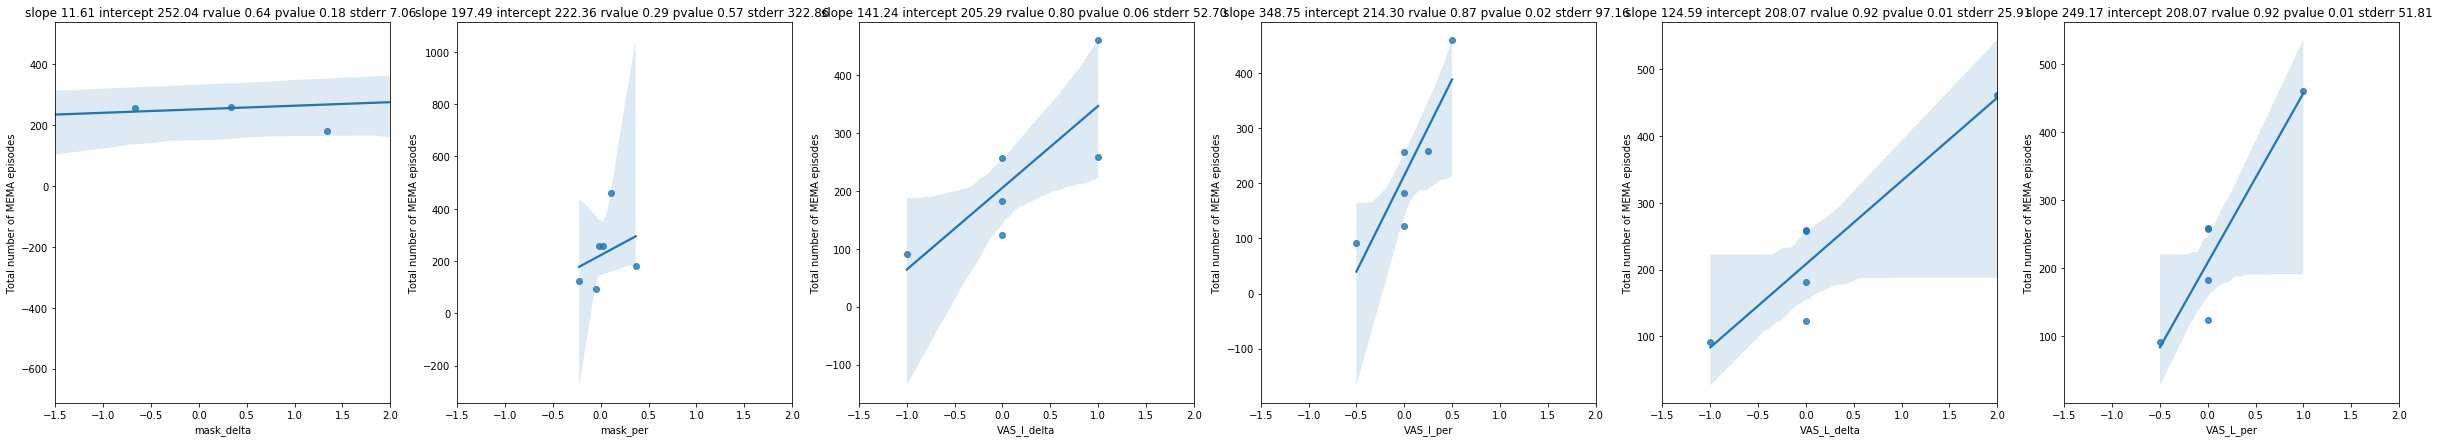

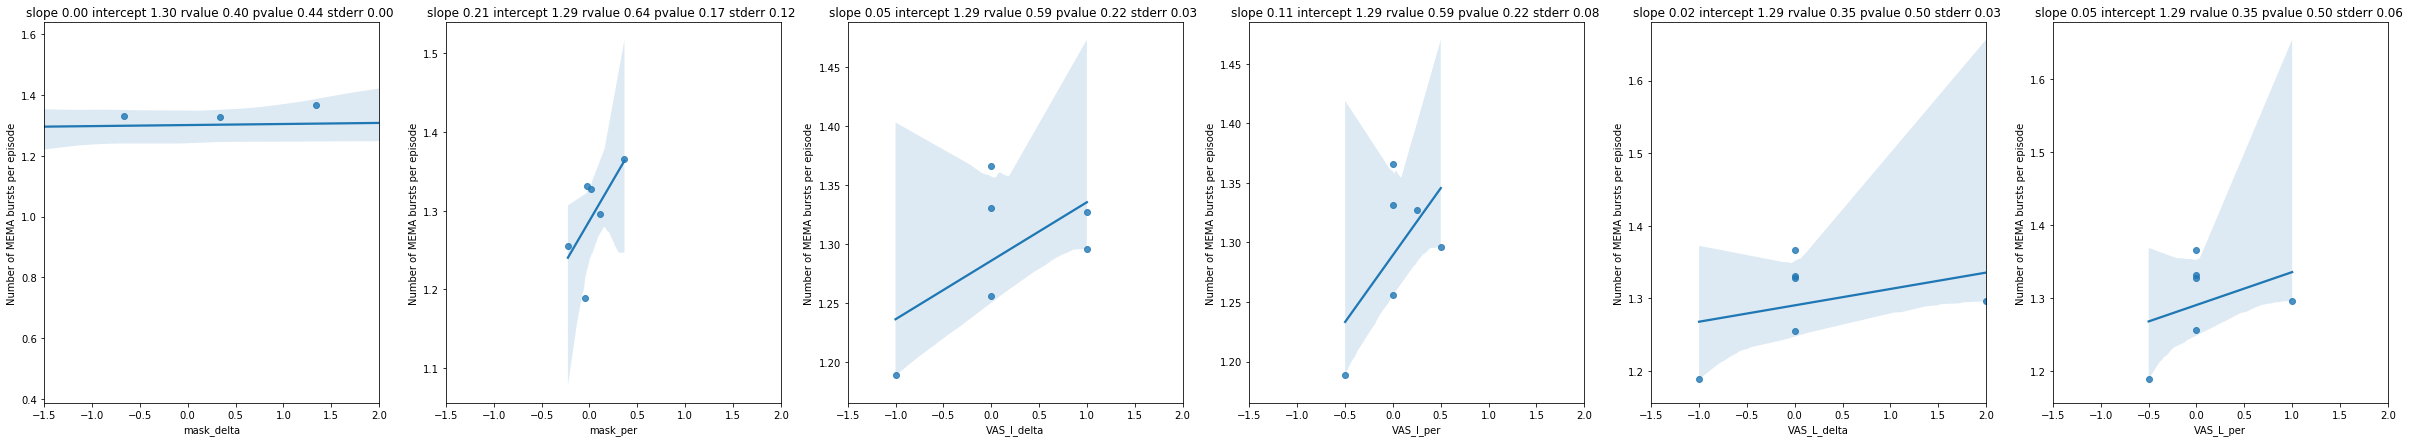

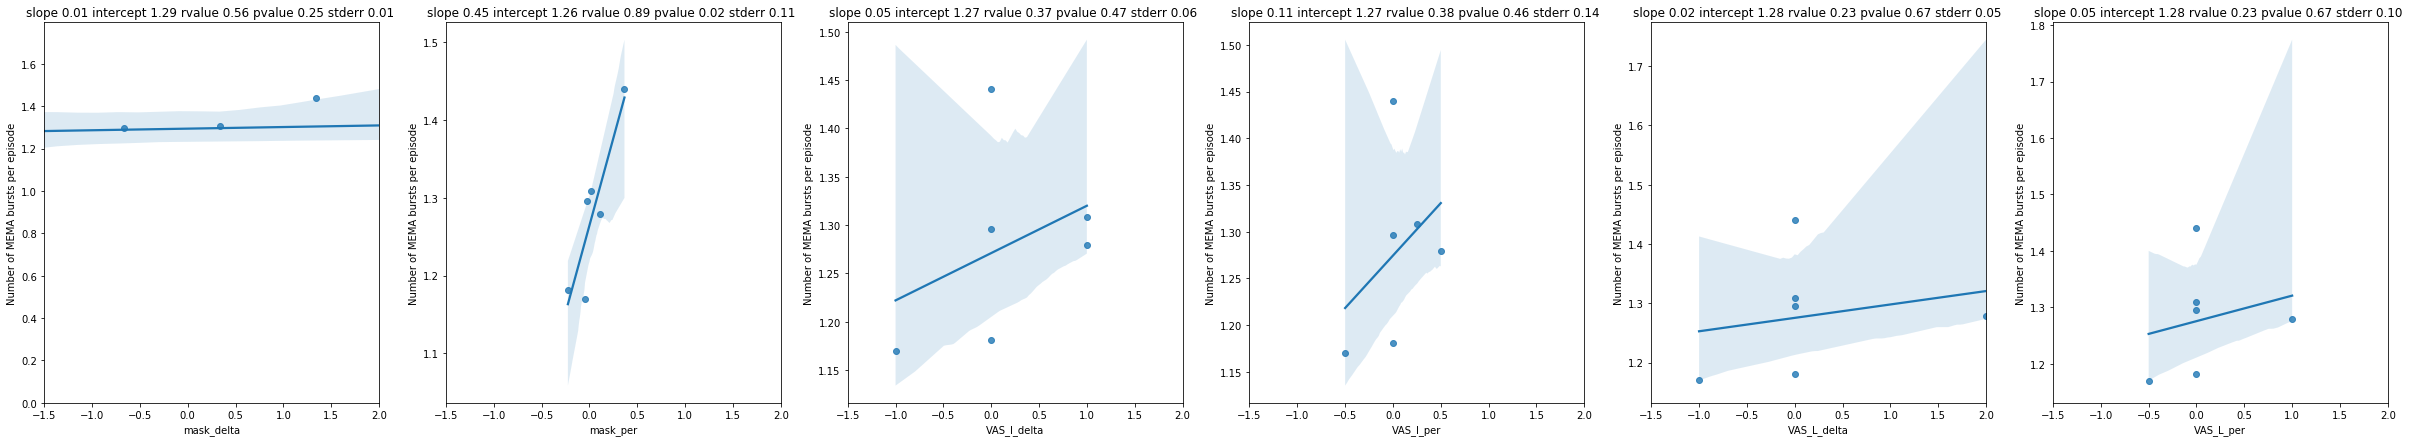

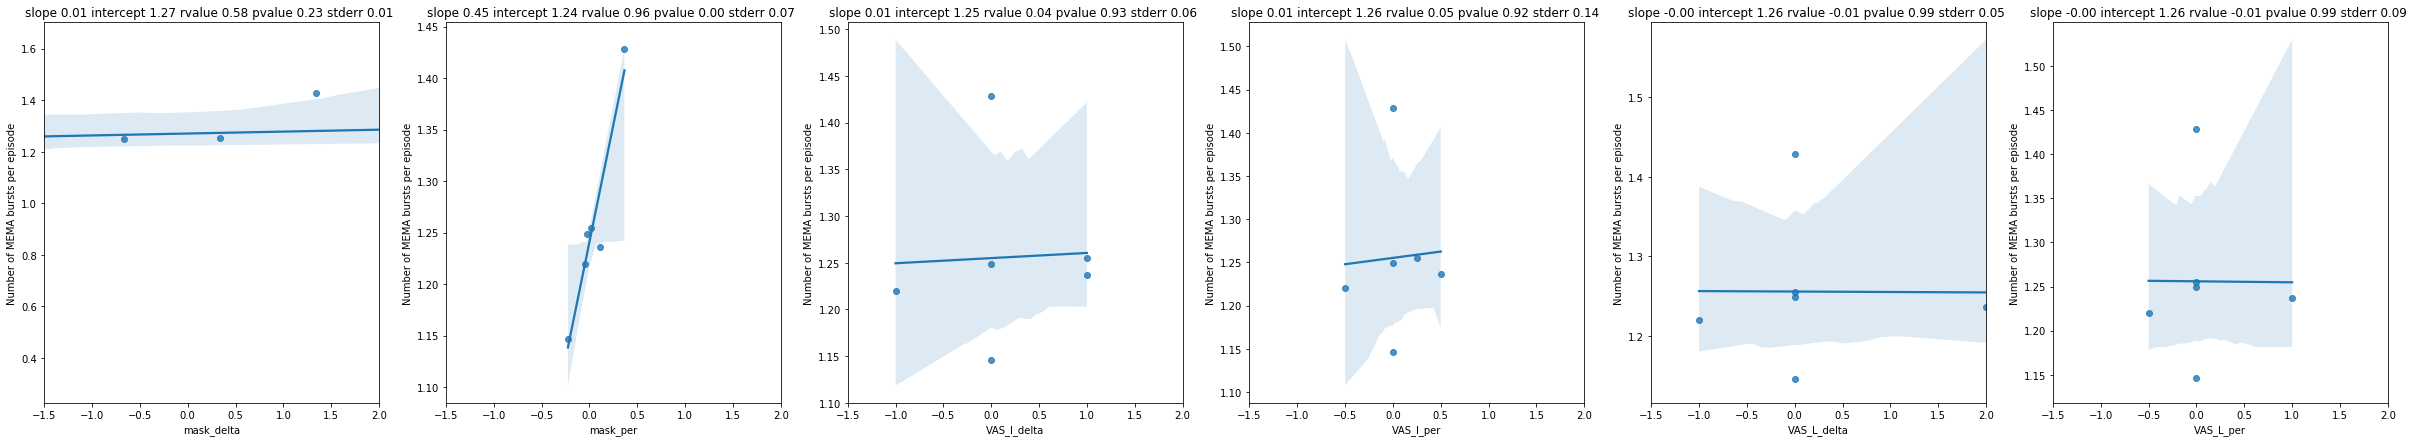

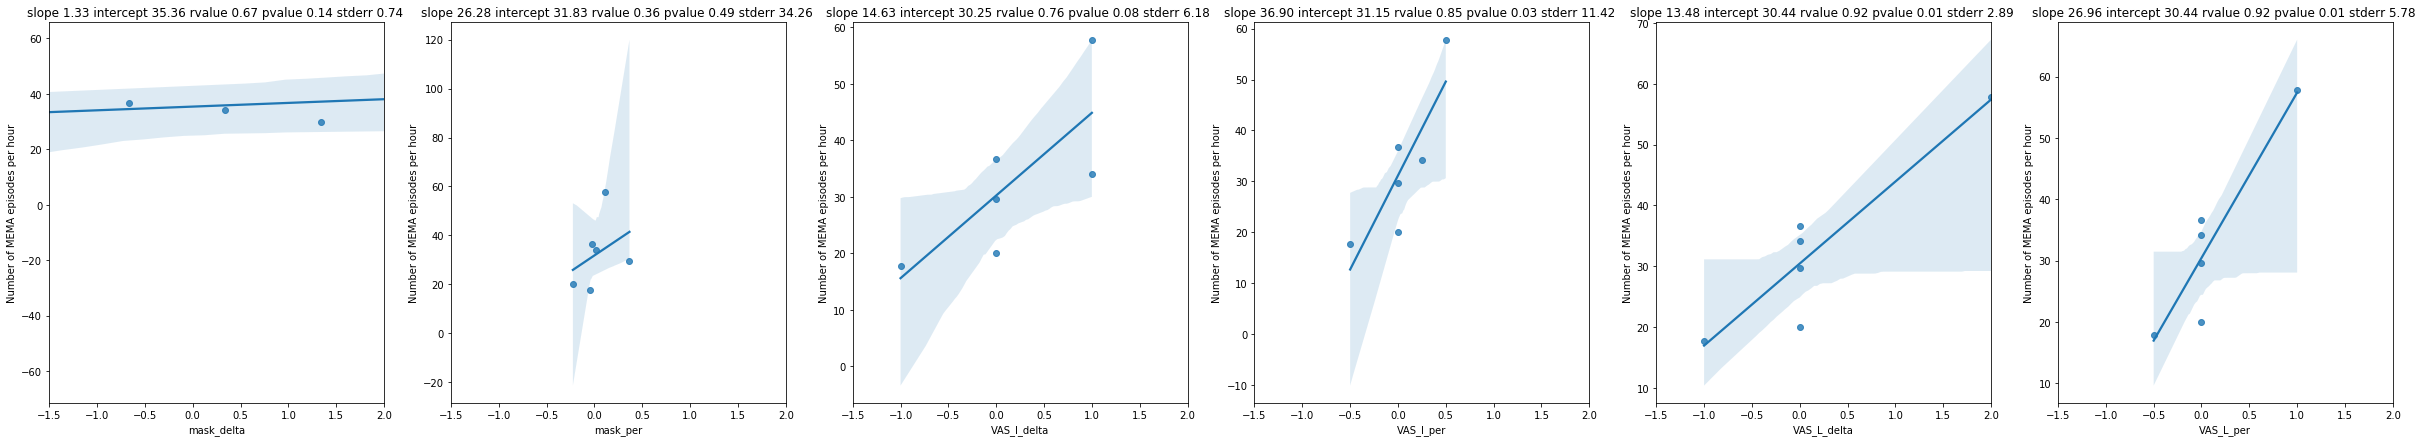

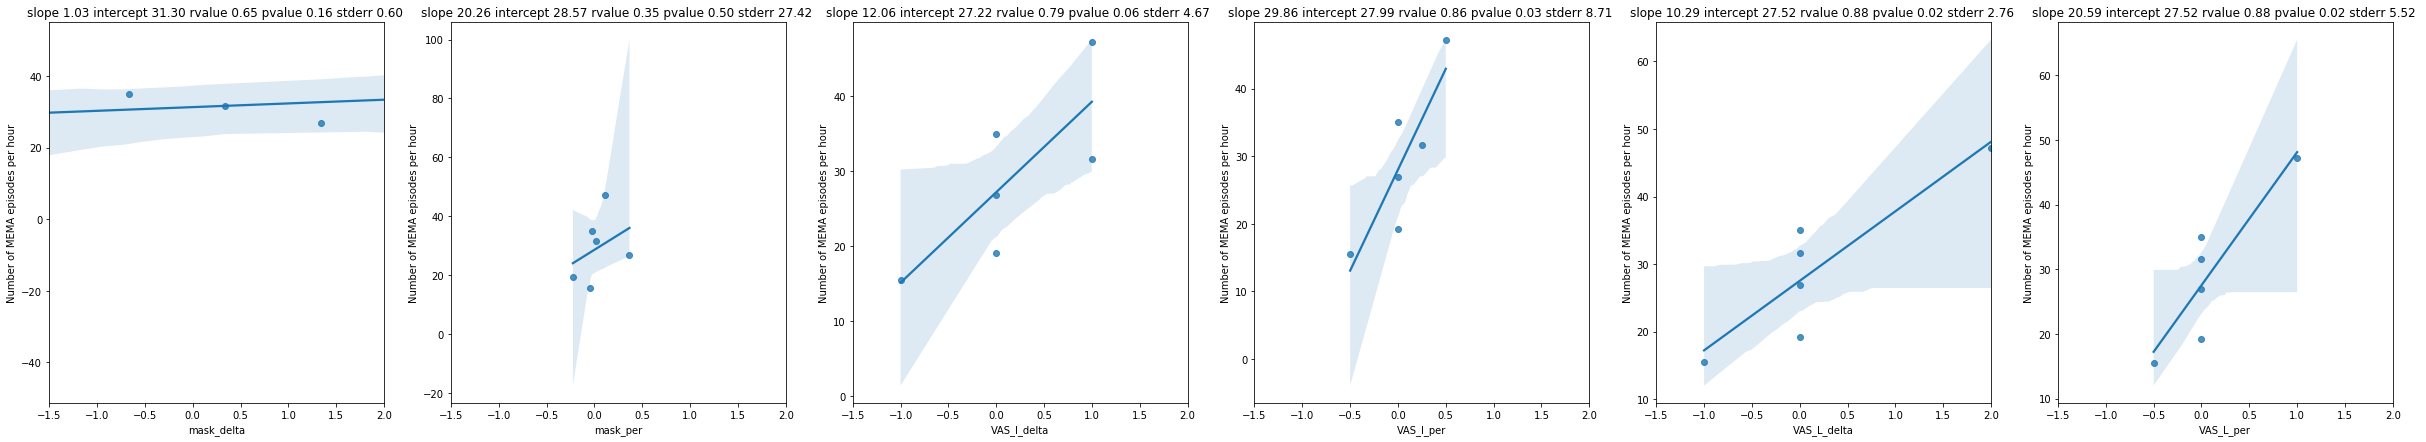

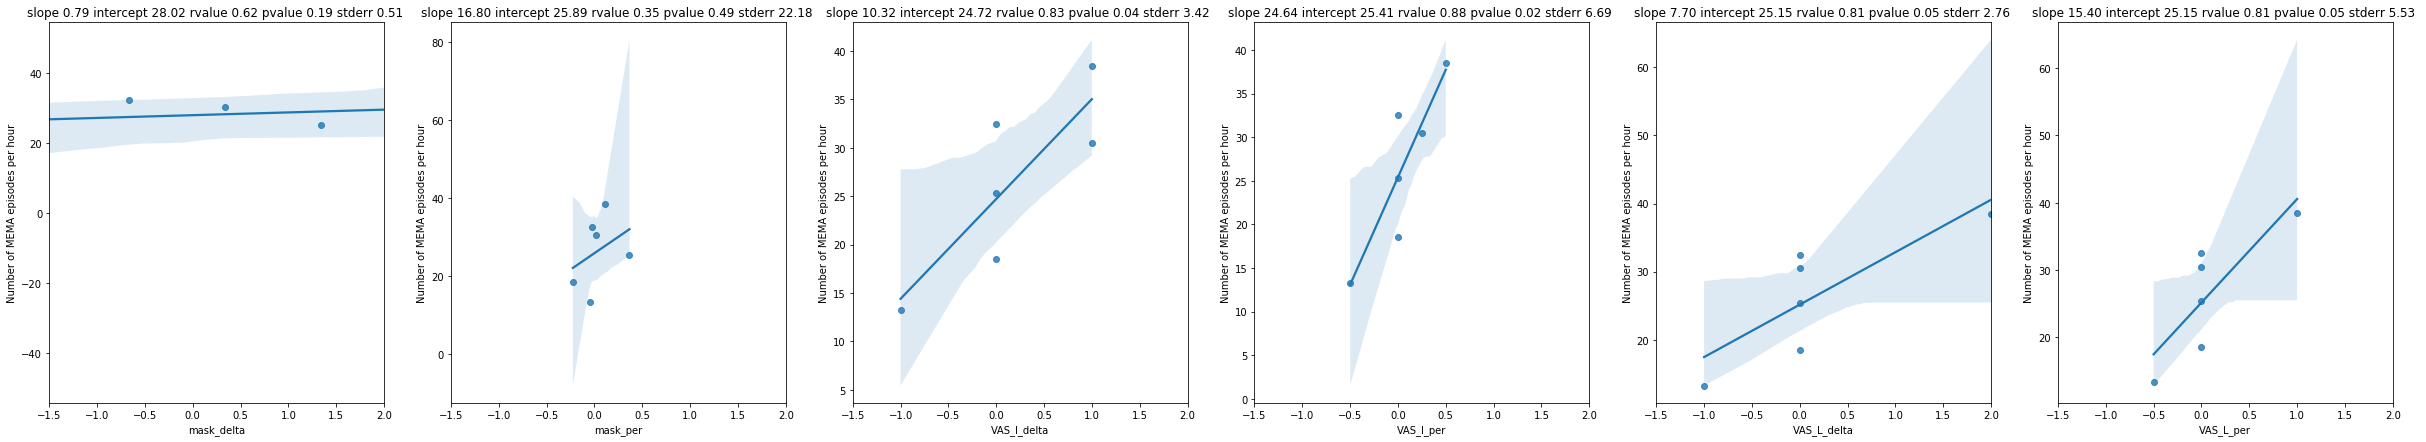

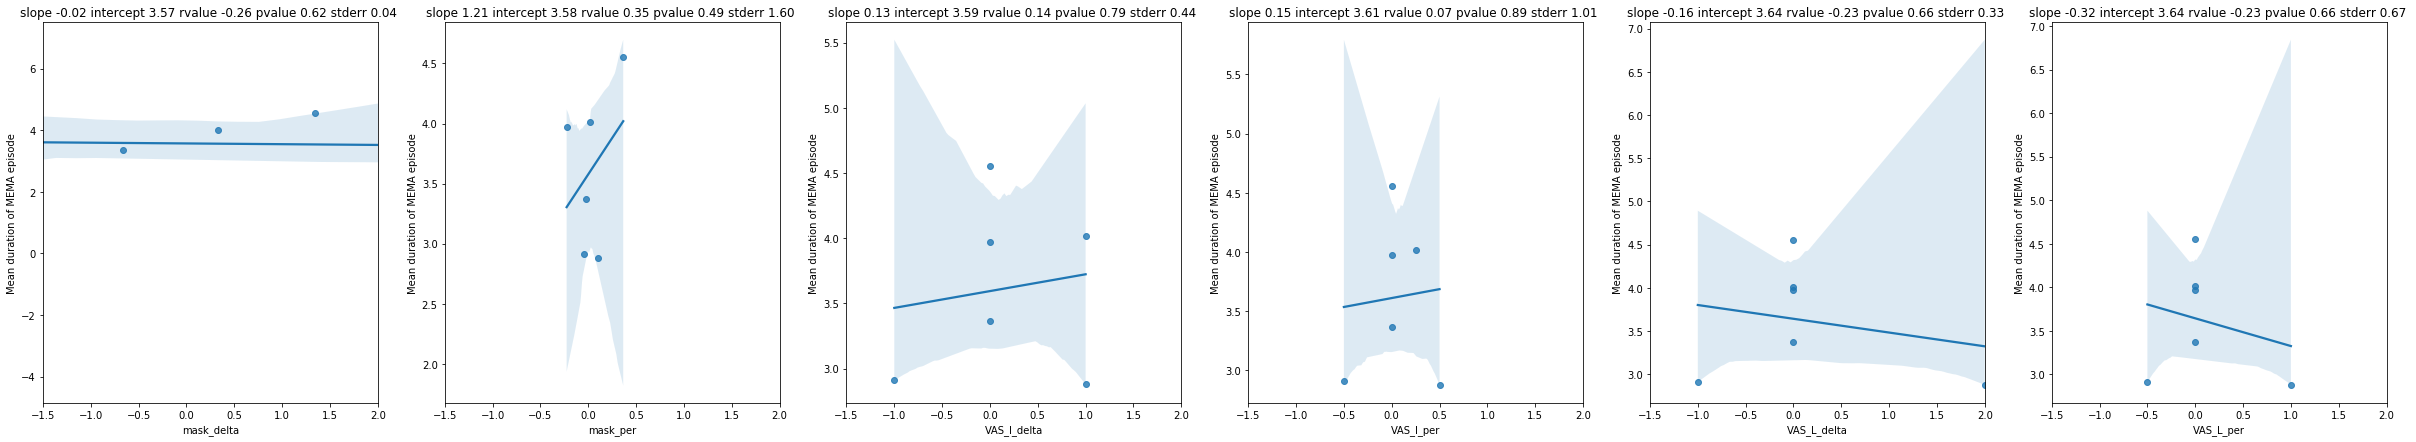

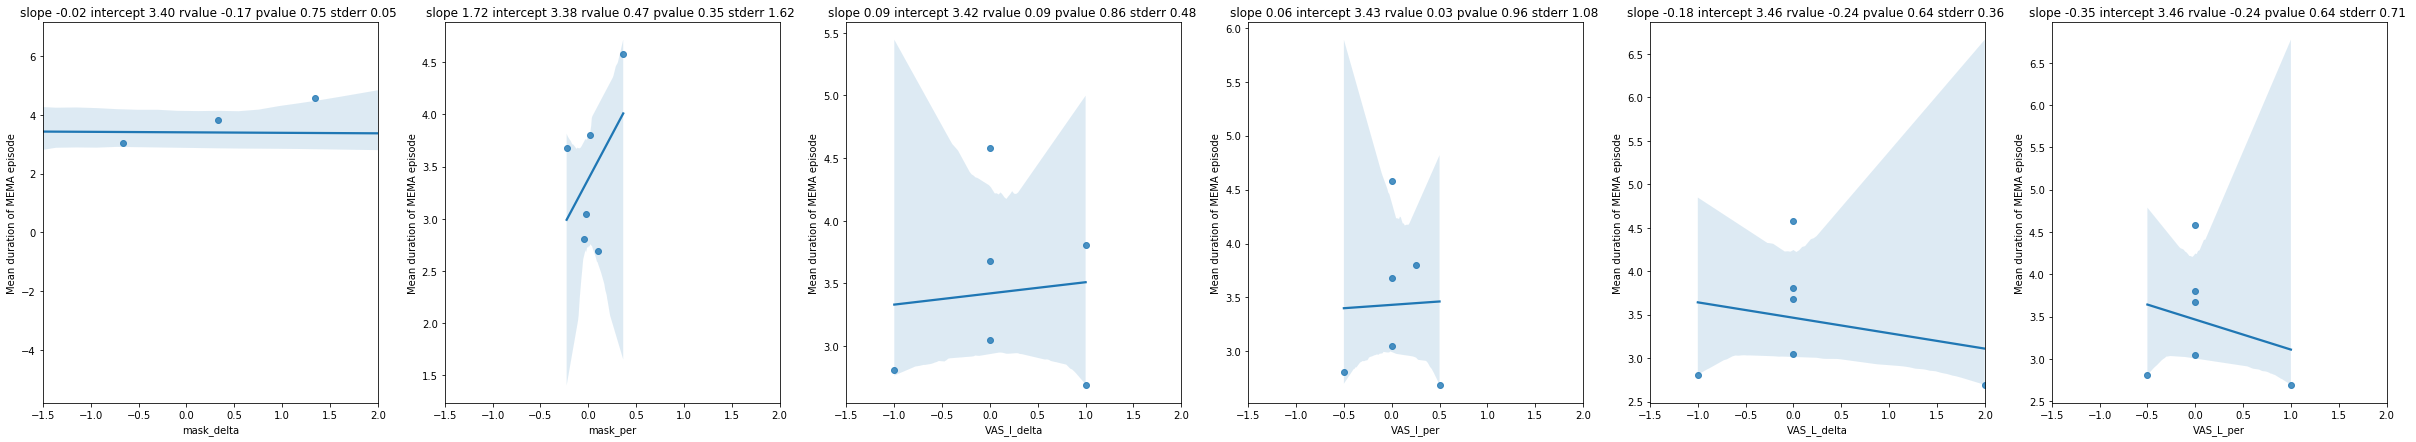

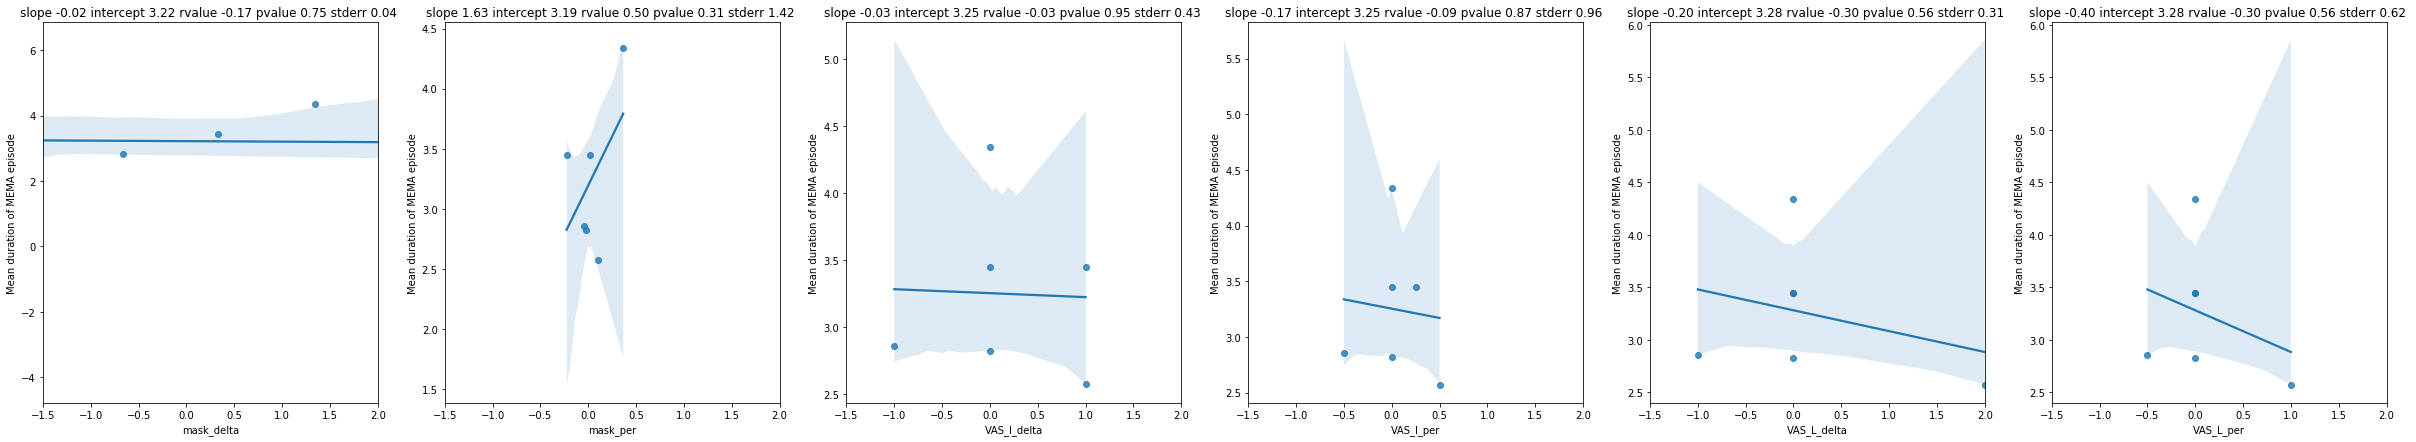

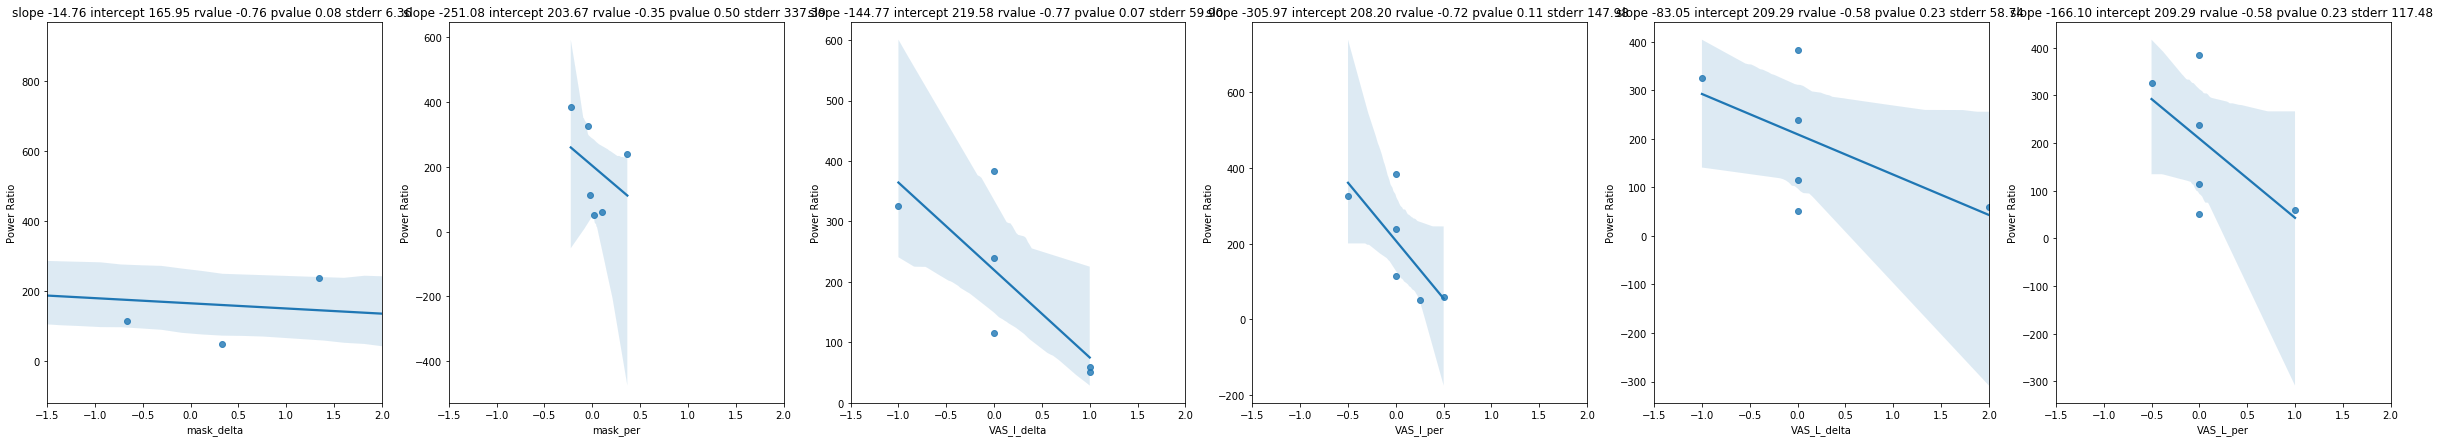

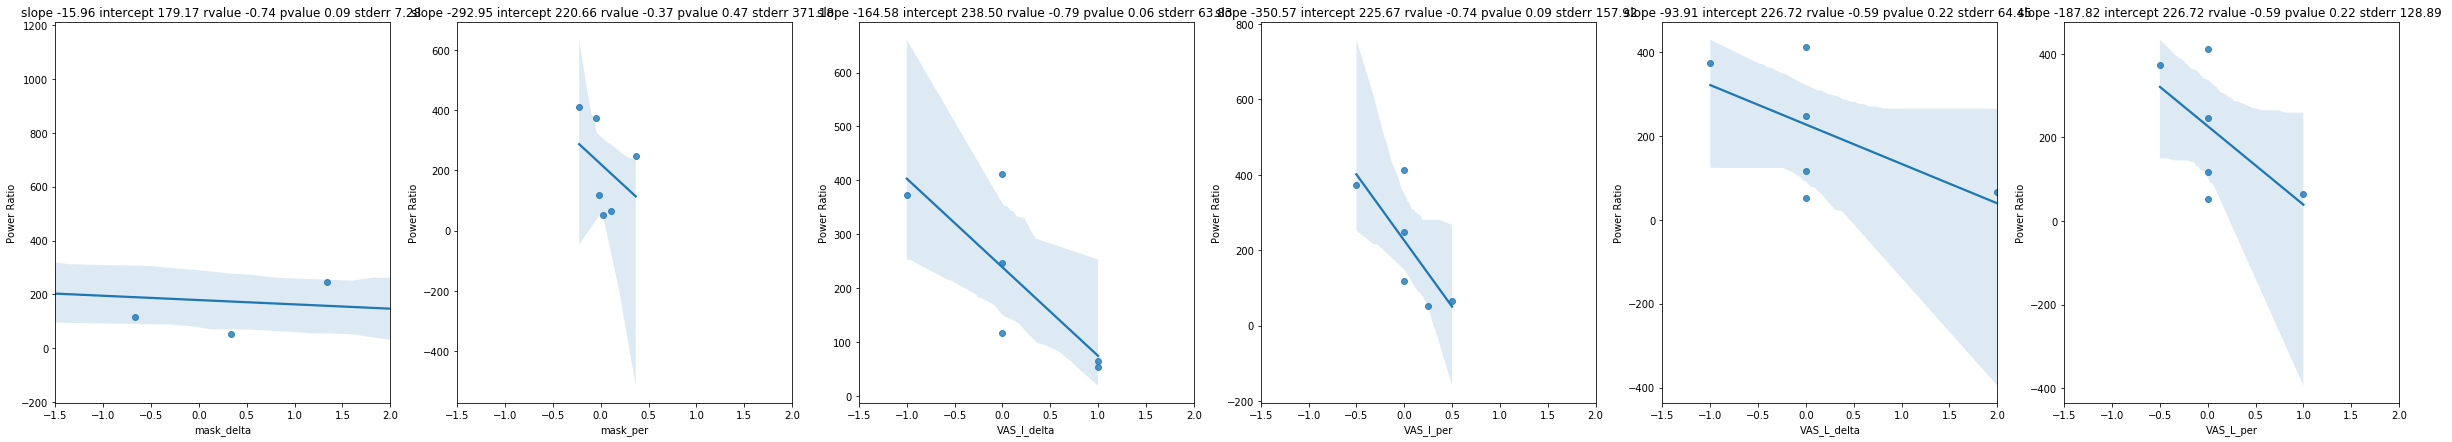

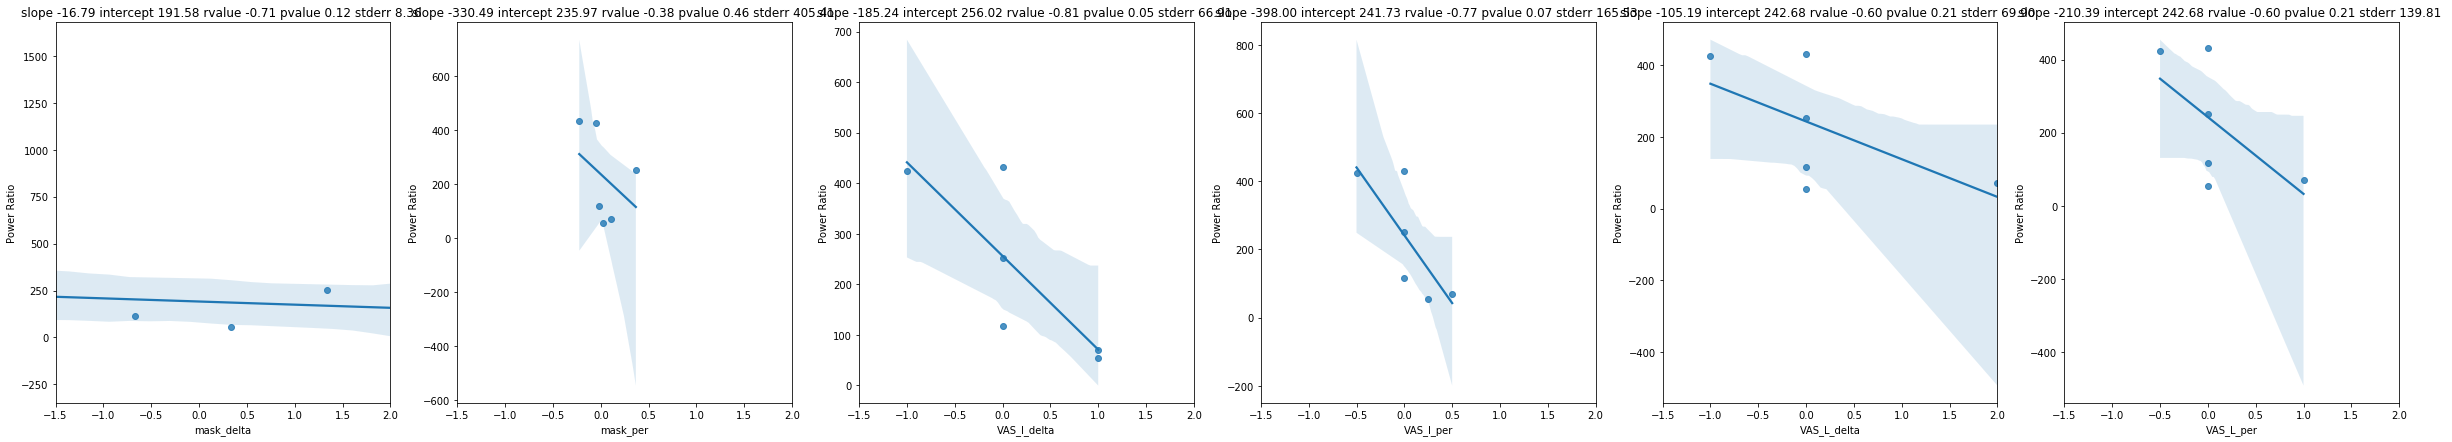

In [13]:
meta_results = pd.DataFrame()
import seaborn as sns
data = reports.query("category != 'control'")
for y_axis in quantitative_variables:
    for threshold in reports["THR_classif"].unique():
        data_loc = data[data["THR_classif"]==threshold]
        f, axes = plt.subplots(1, len(effect_variable), figsize=(len(effect_variable)*7, 7), sharex=True)
        for x_axis, ax in zip(effect_variable, axes):
            sns.regplot(x=x_axis,y=y_axis,data=data_loc,fit_reg=True, ax=ax)
            regression_result = scipy.stats.linregress(data_loc[x_axis].values,data_loc[y_axis].values)
            tmp = {"x_axis":x_axis, "y_axis":y_axis, "THR_classif": [threshold]}
            title = ""
            for a, re in zip(regression_result._fields, regression_result):
                title = title + f"{a} {re:.2f} "
                tmp[a] = [re]
            ax.set_title(f"{title}")
            ax.set_xlim(min(data_loc[x_axis].values)-1,max(data_loc[x_axis].values)+1)
            meta_results = pd.concat([meta_results, pd.DataFrame(tmp)])

In [14]:
meta_results.query("pvalue < 0.05")

,x_axis,y_axis,THR_classif,slope,intercept,rvalue,pvalue,stderr
0,VAS_L_delta,Clean MEMA duration,3.0,6658.281379,28322.705103,0.913298,0.010950,1484.659129
0,VAS_L_per,Clean MEMA duration,3.0,13316.562759,28322.705103,0.913298,0.010950,2969.318257
0,VAS_L_delta,Clean MEMA duration,3.5,6658.281379,28322.705103,0.913298,0.010950,1484.659129
0,VAS_L_per,Clean MEMA duration,3.5,13316.562759,28322.705103,0.913298,0.010950,2969.318257
0,VAS_L_delta,Clean MEMA duration,4.0,6658.281379,28322.705103,0.913298,0.010950,1484.659129
0,VAS_L_per,Clean MEMA duration,4.0,13316.562759,28322.705103,0.913298,0.010950,2969.318257
0,VAS_I_delta,Total MEMA burst duration,3.0,533.810353,774.728941,0.854950,0.030034,161.935535
0,VAS_I_per,Total MEMA burst duration,3.0,1293.564981,809.798792,0.914524,0.010647,286.098123
0,VAS_L_delta,Total MEMA burst duration,3.0,442.774897,789.901517,0.926213,0.007966,90.112129
0,VAS_L_per,Total MEMA burst duration,3.0,885.549793,789.901517,0.926213,0.007966,180.224258
